# Exercicios

<br>
<img src="img\imdb.png" >
<br>

Utilize o dataset train.csv para os exercicios.

#### Estamos em 2015 e você trabalha em uma empresa que compra filmes para passar no cinema. Bons filmes custam caro, assim como filmes ruins barato, mas Bons filmes atraem mais público. Seu chefe sabe que você está aprendendo Machine Learning e te propõe a seguinte tarefa:  - Precisamos achar uma boa oportunidade que nos faça aumentar o lucro da empresa!

Você conseguirá aumentar o lucro da empresa quando comprar um filme que é subvalorizado mas que as features dele indicam que será um bom filme.

Se pudessemos descobrir quais filmes que as pessoas acham que seriam ruins mas na verdade são bons, poderiamos investir apenas nestes e ganhar a diferença já que foi mal precificado.


Vamos partir dos seguintes pressupostos:
- Um filme bom ou ruim do ponto de vista de quem está precificando será o tamanho do seu orçamento (budget).

- Um filme Bom/Ruim do ponto de vista do público serão filmes com altas notas (imdb_score).

Então vamos procurar os filmes que tenham uma boa relação entre budget e score.
(é como se quisessemos comprar scores pois isso que o público quer ver mas os donos dos filmes vendem baseado no budget do filme).

O primeiro passo é entendermos bem o problema e os dados disponíveis.

Por exemplo, se vamos comprar um filme, algumas features não estarão disponiveis antes da compra (elas são criadas apenas após a compra) para predizer o rating como as vendas de ingresso, faturamento, etc.

Depois separamos nos nossos dados quais serão nossas variáveis explicativas (Os X) e qual é nossa variável target (nosso Y).

Caso algumas das nossas variáveis explicativas sejam categórias, precisamos transforma-las em numéricas para que o modelo consiga entende-la.

Podemos utilizar uma função do pandas dessa forma:

``` df = pd.get_dummies(df) ```

O último passo antes de rodar um modelo é dividir nossos dados em duas partes, uma para treinar o modelo e outra para testa-lo, podemos fazer uma amostra aleatória ou usar a função do sklearn que nos ajuda com isso:

```
from sklearn.model_selection import train_test_split

 X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.33, random_state=42)
```
Para isso Treine um Modelo de Machine Learning supervisionado que aprenda a predizer as notas dos filmes.

Utilize os 4 passos visto na primeira aula de machine learning:
```from sklearn.linear_model import LinearRegression```

Após treinar o modelo vamos ver como estão as [métricas](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) de assertividade.

Analisar o R2, RMSE, MSE. Qual é o melhor nesse caso?

Exemplo do MSE
```
from sklearn.metrics import mean_squared_error

mean_squared_error(y_true, y_pred)
```

Como poderiamos melhorar esse modelo? Será que existe algum método para colocar todas as variáveis ao quadrado, cubo, etc para que possamos capturar efeitos não lineares? Óbviamente existe e já foi implementado no sklearn, podemos usar a função:

```
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)

df = poly.fit_transform(df)
```

Aparentemente sempre que aumentamos o grau do polinomio nosso modelo fica melhor, porque não podemos botar um número alto como 10?

Rode o algoritmo com um grau = 10 e compare as métricas de treino contra as métricas de teste. O que está acontecendo?

Parece que estamos chegando perto de um modelo bom para nosso objetivo de identificar oportunidade nos filmes. Será que poderiamos utilizar outro método de regressão mais robusto? Vamos tentar utilizar um dos melhores métodos que utiliza arvores aleatórias (usado geralmente em classificação e as estudaremos mais profundamente no módulo 4) como modelo:

Treine agora o mesmo modelo utilizando um modelo não-linear (não exige que as correlações sejam lineares) e compare as métricas.

```from sklearn.ensemble import RandomForestRegressor```



Agora estamos em 2016. Use seu modelo treinado com todos os filmes até 2015 para responder a pergunta do seu chefe com os filmes que apareceram em 2016: Quais são os filmes que são realmente oportunidades de ganhar dinheiro (altos ratings, baixo custo).

# Passo 1 - Entender o problema

O problema está descrito no tutorial acima. O que não está escrito é qual abordagem deveriamos ter para resolve-lo.

Vamos pensar em uma possibilidade de solução aqui e escreveremos todo o restante do código pensando em como alcançar esse resultado.

Não existe um só caminho para resolver esse problema, mas a solução que eu pensei em aplicar é a seguinte:

    1) de um lado os donos dos filmes precificam seus produtos com base em quanto gastaram.

    2) Seguindo o pressuposto do problema, o sucesso de bilheteria do filme depende apenas das notas que as pessoas vão dar a ele.

Com isso chegamos a conclusão que o melhor filme para apostarmos são aqueles que a relação entre o preço (1-custo) e o (2-receita) é a mais vantajoso para nós.

Uma forma de pensar é que temos que "comprar" scores então procuraremos os scores mais baratos que será dado por (1)/(2) -> custo do filme / beneficio do filme.

Então precisamos treinar um modelo de machine learning que quando chegar um filme novo, prediga com o máximo de acurácia a nota média que as pessoas darão para ele ( o quociente na nossa equação) já que o númerador (o custo do filme) já saberemos.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_raw = pd.read_csv("imdb_train.zip")

In [3]:
# agora vamos fazer uma cópia do nosso dataframe.
# Note que usamos a função deep=True pois só assim garantimos que o 
# dado está duplicado e não é apenas um "atalho" para o dataset original
df = df_raw.copy(deep=True)

# Passo 2 - Escolher as variáveis.


Definido claramente o que vamos fazer, vamos olhar as variáveis disponiveis e ver o que faz ou não sentido incluir.

Diferentemente de modelagem estatistica, em machine learning não estamos preocupados com as variáveis serem correlacionadas, então não há um bom motivo (por hora) para retirarmos variáveis do modelo, portanto, meu primeiro modelo de 'benchmark' terá o máximo de variáveis/features possível.

Algumas são facilmente excluidas, pois mesmo que sejam boas preditoras como o tamanho da bilheteria, ela só estará disponível após o filme ser lançado. Parte bastante importante da definição de um modelo de machine learning é pensar nesses pontos, de quais variáveis estarão disponiveis em um modelo de produção e isso, muitas vezes, pode ser bastante complicado por conta do carater temporal das variáveis tornando-se um "leakage" ou seja, um vazamento de dados.


Variáveis como gross sabemos que não estará disponivel antes do lançamento então não vamos usa-la para treinar nosso modelo.

Outra variável que não faz sentido para um modelo de machine é aquela que identifica o filme como um id, index ou o nome do filme.

In [4]:
list(df_raw)

['Unnamed: 0',
 'color',
 'director_name',
 'num_critic_for_reviews',
 'duration',
 'director_facebook_likes',
 'actor_3_facebook_likes',
 'actor_2_name',
 'actor_1_facebook_likes',
 'gross',
 'genres',
 'actor_1_name',
 'movie_title',
 'num_voted_users',
 'cast_total_facebook_likes',
 'actor_3_name',
 'facenumber_in_poster',
 'plot_keywords',
 'movie_imdb_link',
 'num_user_for_reviews',
 'language',
 'country',
 'content_rating',
 'budget',
 'title_year',
 'actor_2_facebook_likes',
 'imdb_score',
 'aspect_ratio',
 'movie_facebook_likes']

In [5]:
columns_to_drop = ['Unnamed: 0', 'gross', 'movie_title', 'plot_keywords']

In [6]:
df = df_raw.drop(columns_to_drop, axis=1)

In [7]:
list(df)

['color',
 'director_name',
 'num_critic_for_reviews',
 'duration',
 'director_facebook_likes',
 'actor_3_facebook_likes',
 'actor_2_name',
 'actor_1_facebook_likes',
 'genres',
 'actor_1_name',
 'num_voted_users',
 'cast_total_facebook_likes',
 'actor_3_name',
 'facenumber_in_poster',
 'movie_imdb_link',
 'num_user_for_reviews',
 'language',
 'country',
 'content_rating',
 'budget',
 'title_year',
 'actor_2_facebook_likes',
 'imdb_score',
 'aspect_ratio',
 'movie_facebook_likes']

# Passo 3 - Tratando as variáveis.

**Essa é a etapa mais longa, mais importante e mais dificil de um problema de machine learning.** (falaremos mais sobre essas técnicas nas próximas aulas)

Essa etapa podemos usar todos os tratamentos de variáveis que aprendemos na modelagem estatistica quando estavamos rodando regressões simples. Não vou repetir os tratamentos mas todos podem ser utilizados.


#### Campos nulos.

Quando rodamos um dff.describe() percebemos muitos campos nulos e há diversas formas de trata-los.

Alternativas para tratar nulos.

1) Deleter todos os nulos.

```
df = df.dropna()
```

2) Substituir os nans pelas médias (nas numéricas) ou modas (nas categóricas).

df['numericas'] = df['numericas'].fillna(df.mean())


3) rodar um "pré-ML" que prevê os valores faltantes.



4) Usar um algoritmo robusto para campos nulos.

ex:

```
import xgboost as xgb
```

Vamos usar uma abordagem mista. Nas variáveis numéricas vamos substituir pela média e nas variáveis categóricas vamos excluir as linhas com campos nulos para aprender as duas metodologias. 

(conforme vimos em estatistica, excluir linhas que não são aleatórias enviesam nosso modelo e não deve ser feito a menos que você tenha certeza que aqueles nulos são por alguma falha aleatória o que é bastante raro. Não sendo aleatório devemos tratar com uma das outras metodologias, principalmente a número 4).

In [8]:
df.dtypes

color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
genres                        object
actor_1_name                  object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
movie_facebook_likes         float64
dtype: object

In [10]:
df_numeric = df.select_dtypes(include=[np.number]) # dataset apenas com colunas numéricas.
numericas = list(df_numeric)

In [11]:
# Nessa função selecionamos todas as colunas númericas e substituimos seus 
# valores pelas médias das colunas. A função fillna retorna todos os campos 
# nulos e a função df.mean retorna as médias de cada coluna.
df[numericas] = df[numericas].fillna(df.mean())

In [12]:
# já nas variáveis categóricas (que contém texto ao invés de números)
# vamos substituir os campos nulos por uma nova string que representa que aquele campo é faltante.
df = df.fillna('na') # substitui os dados faltantes por 'na'
df = df.dropna() # se sobrar alguma linha (nao deveria), dropamos essas linhas.
df.shape

(4937, 25)

In [13]:
df.shape

(4937, 25)

Nossa segunda etapa de tratamento das variáveis consiste em transformar as variáveis em funções lineares (se estivermos rodando modelos lineares) através da aplicação de log nas variáveis "explosivas" tornando-a linear. Não faremos essa etapa pois nosso objetivo é rodar um algoritmo não linear em seguida.

A terceira etapa de preparação dos dados é criar variáveis dummies para nossas features categóricas.

Basicamente os algoritmos de machine learning não conseguem interpretar textos como o genêro de um filme ou os atores que participaram então precisamos transformar essas colunas categóricas em colunas numéricas para que o algoritmo possa capturar seus efeitos e predizer nosso target.

Substituir as categorias por números dessa forma: COluna genêro de filme com valores [Terror=1, Comédia=2, Ação=3] embora faça o algoritmo rodar, não funcionará bem como variável explicativa pois elas não representam uma sequencia numérica. A forma mais simples de fazermos isso virar uma variável explicativa é pegar cada uma das categorias possíveis e transformar em uma coluna forma única que recebe apenas dois valores, 0 e 1. 0 se o valor não estiver presente e 1 caso esteja presente. Dessa forma nossa  representação ficará da seguinte forma. 

- Coluna 1 = genero_terror
- Coluna 2 = genero_comédia
- Coluna 3 = genero_ação

Assumindo 1 ou 0 dependendo do filme.

Uma observação sobre essa técnica é que não é necessário colocar todas as possibilidades, uma delas se torna redundante e ao modelar esse caso podemos excluir uma delas.

Essa técninca chamamos de one_hot (sklearn) e no pandas temos a função get_dummies que faz o mesmo processo.

In [14]:
# df = pd.get_dummies(df, drop_first=True)

In [15]:
df.shape

(4937, 25)

Aumentamos das 26 colunas originais para mais de 15mil colunas!

# Passo 4 - Treinando o modelo de Machine Learning

Essa é a etapa mais simples mas que exige mais experiência.

1) qual algoritmos escolher?

Sabemos que nosso problema se trata de prever uma variável continua (uma nota) e como temos diversas notas para treina-lo podemos usar uma abordagem supervisionado.

(obs: poderiamos tentar transformar cada intervalo de notas em uma categoria, ex: [0,1] -> 1, [1,2] -> 2 .... [9,10] -> 10 e prever usando um algoritmo de classificação, mas como as notas fazem sentido como uma variável numérica, ou seja, a nota seguinte é a nota anterior + 1, um algoritmo de classificação dificilmente superaria um de regressão já que as probabilidades de cada classe prevista em uma classificação é independente, é como se uma nota não tivesse nenhuma relação com a outra e isso não é verdade no nosso caso).

Então:

    Supervisionado -> Regressão
    
    
Mas há dezenas de algoritmos de regressão (ver todos os disponiveis no sklearn nesse link: http://scikit-learn.org/stable/supervised_learning.html )

Alguns deles:
- MQO (o mais simples que estudamos em estatistica e abrimos o código na aula2 de machine learning).
- Ridge -> Método de Shrinkage. Conrola sobreajuste com L1

    $L = ∑( Ŷi– Yi)^2 + λ∑ β^2$


- lasso -> Também método de Shrinkage. controle sobreajuste com L2

   $ L = ∑( Ŷi– Yi)^2 + λ∑ |β|$


- elasticnet -> combinação de Lasso + Ridge
- Regressão Bayesiana -> Retorna distribuições de probabilidade ao invés de simples valores.

    Ex: https://towardsdatascience.com/introduction-to-bayesian-linear-regression-e66e60791ea7?gi=392eaf9ea3b 
    
- Arvores aleatórias -> insere não lineariedades
- Redes neurais -> também insere não lineariedades.
- Ensambles -> Combinação de diferentes modelos.
- Etc


Qual usar ?

No nosso exemplo vamos usar o mais simples MQO para usar de comparativo e um extremamente poderoso que são as arvores aleatórias (que ainda não vimos seu funcionamento).

Na prática, quando colocamos um modelo em produção, podemos rodar diferentes algoritmos (que tem suas próprias vantagens e desvantagens) e pegar uma combinação desses diferentes algoritmos como o resultado final. A essa combinação de modelos damos o nome de **ensamble**.

Para rodar qualquer modelo de machine learning desses, vamos passar pelos mesmos passos:

    1) Importar o modelo desejado.
    2) Instanciar em uma variável com os parâmetros desejados (ainda não vimos os parâmetros).
    3) Separar nossos dados em variáveis explicativas (X) e explicadas/target (Y)
    4) Separar nossos dados em Treino e Teste
    5) Treinar o Modelo com o .fit()
    6) Analisar as métricas, se não estiver boas, voltamos aos passos anteriores de trabalhar com as variáveis.
    7) Estando tudo ok, rodamos previsões

**1) Importar modelos**

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

**2) Instanciar os modelos em variáveis**

In [17]:
modelo_MQO = LinearRegression()
modelo_RF = RandomForestRegressor()

**3) Separar os dados em X e Y**

In [18]:
numericas

['num_critic_for_reviews',
 'duration',
 'director_facebook_likes',
 'actor_3_facebook_likes',
 'actor_1_facebook_likes',
 'num_voted_users',
 'cast_total_facebook_likes',
 'facenumber_in_poster',
 'num_user_for_reviews',
 'budget',
 'title_year',
 'actor_2_facebook_likes',
 'imdb_score',
 'aspect_ratio',
 'movie_facebook_likes']

In [19]:
df_raw[numericas] = df_raw[numericas].fillna(df_raw[numericas].mean())

In [20]:
df.corr()['imdb_score']

num_critic_for_reviews       0.303987
duration                     0.261837
director_facebook_likes      0.168952
actor_3_facebook_likes       0.052178
actor_1_facebook_likes       0.069684
num_voted_users              0.414215
cast_total_facebook_likes    0.079983
facenumber_in_poster        -0.058702
num_user_for_reviews         0.294641
budget                       0.027775
title_year                  -0.209660
actor_2_facebook_likes       0.082535
imdb_score                   1.000000
aspect_ratio                 0.059623
movie_facebook_likes         0.249753
Name: imdb_score, dtype: float64

In [22]:
X = df[numericas].drop(['imdb_score'], axis = 1)
y = df['imdb_score']

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

In [27]:
model_regressao_linear = LinearRegression()

In [28]:
model_regressao_linear.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [30]:
model_regressao_linear.score(X, y)

0.285021028993076

In [32]:
# novo_X = X.sample(100)

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

# MOstrando a estocasticidade do test

In [ ]:
from sklearn.model_selection import train_test_split

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05)

model_regressao_linear.fit(X_train, y_train)
model_regressao_linear.score(X_test, y_test)

0.32994475208636975

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05)

model_regressao_linear.fit(X_train, y_train)
model_regressao_linear.score(X_test, y_test)

0.2981721151204164

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05)

model_regressao_linear.fit(X_train, y_train)
model_regressao_linear.score(X_test, y_test)

0.29724577190863355

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05)

model_regressao_linear.fit(X_train, y_train)
model_regressao_linear.score(X_test, y_test)

0.2779917945938709

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05)

model_regressao_linear.fit(X_train, y_train)
model_regressao_linear.score(X_test, y_test)

0.29710611727298475

In [34]:
X_train.shape

(3702, 14)

In [35]:
y_train.shape

(3702,)

In [36]:
model_regressao_linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [37]:
model_regressao_linear.score(X_train, y_train)

0.2921548017405897

In [38]:
model_regressao_linear.score(X_test, y_test)

0.255115722879095

In [52]:
model_megazord = GradientBoostingRegressor(max_depth=6)

In [53]:
model_megazord.fit(X_train, y_train)

model_megazord.score(X_train, y_train)

0.881857052737428

In [54]:
model_megazord.score(X_test, y_test)

0.5116025996393734

In [60]:
for complexidade in range(1,9):
    
    model_megazord = GradientBoostingRegressor(max_depth=complexidade)
    model_megazord.fit(X_train, y_train)

    print(f'Complexidade: {complexidade}, Score de Treino: {round(model_megazord.score(X_train, y_train),4)}, Score de Teste: {round(model_megazord.score(X_test, y_test), 4)}')

Complexidade: 1, Score de Treino: 0.3753, Score de Teste: 0.3587
Complexidade: 2, Score de Treino: 0.505, Score de Teste: 0.4376
Complexidade: 3, Score de Treino: 0.6067, Score de Teste: 0.4737
Complexidade: 4, Score de Treino: 0.7075, Score de Teste: 0.502
Complexidade: 5, Score de Treino: 0.8027, Score de Teste: 0.5073
Complexidade: 6, Score de Treino: 0.8819, Score de Teste: 0.5036
Complexidade: 7, Score de Treino: 0.9413, Score de Teste: 0.5147
Complexidade: 8, Score de Treino: 0.9751, Score de Teste: 0.4917


In [71]:
import xgboost as xgb # 

In [72]:
model = xgb.XGBRegressor()

In [73]:
numericas.append('director_name')

In [79]:
numericas

['num_critic_for_reviews',
 'duration',
 'director_facebook_likes',
 'actor_3_facebook_likes',
 'actor_1_facebook_likes',
 'num_voted_users',
 'cast_total_facebook_likes',
 'facenumber_in_poster',
 'num_user_for_reviews',
 'budget',
 'title_year',
 'actor_2_facebook_likes',
 'imdb_score',
 'aspect_ratio',
 'movie_facebook_likes',
 'director_name']

In [80]:
df_with_dummies=pd.get_dummies(df[numericas], drop_first=True)

df_with_dummies.head()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,...,director_name_Zack Snyder,director_name_Zackary Adler,director_name_Zak Penn,director_name_Zal Batmanglij,director_name_Zoran Lisinac,director_name_na,director_name_Álex de la Iglesia,director_name_Émile Gaudreault,director_name_Éric Tessier,director_name_Étienne Faure
0,723.00000,178.00000,0.0,855.000000,1000.0,886204,4834,0.0,3054.000000,2.370000e+08,...,0,0,0,0,0,0,0,0,0,0
1,302.00000,169.00000,563.0,1000.000000,40000.0,471220,48350,0.0,1238.000000,3.000000e+08,...,0,0,0,0,0,0,0,0,0,0
2,602.00000,148.00000,0.0,161.000000,11000.0,275868,11700,1.0,994.000000,2.450000e+08,...,0,0,0,0,0,0,0,0,0,0
3,813.00000,164.00000,22000.0,23000.000000,27000.0,1144337,106759,0.0,2701.000000,2.500000e+08,...,0,0,0,0,0,0,0,0,0,0
4,139.92657,107.14872,131.0,644.082621,131.0,8,143,0.0,274.585926,3.940027e+07,...,0,0,0,0,0,0,0,0,0,0


In [81]:
y = df_with_dummies['imdb_score']
X = df_with_dummies.drop(['imdb_score'], axis=1)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [83]:
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

C:\Users\marcos.silva\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:20:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.5749486113575363
0.4776099629558722


In [85]:
del numericas[-1]

In [86]:
numericas

['num_critic_for_reviews',
 'duration',
 'director_facebook_likes',
 'actor_3_facebook_likes',
 'actor_1_facebook_likes',
 'num_voted_users',
 'cast_total_facebook_likes',
 'facenumber_in_poster',
 'num_user_for_reviews',
 'budget',
 'title_year',
 'actor_2_facebook_likes',
 'imdb_score',
 'aspect_ratio',
 'movie_facebook_likes']

In [87]:
df_with_dummies=pd.get_dummies(df[numericas])

In [88]:
df_with_dummies.shape[1] == df[numericas].shape[1]

True

In [89]:
y = df_with_dummies['imdb_score']
X = df_with_dummies.drop(['imdb_score'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

C:\Users\marcos.silva\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:22:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.6075189343263261
0.46908608215660774


In [65]:
from sklearn.model_selection import cross_val_score

In [67]:
cross_val_score(model, X, y, cv=10, )

C:\Users\marcos.silva\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\marcos.silva\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\marcos.silva\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\marcos.silva\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\marcos.silva\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:58

array([0.48753444, 0.57315798, 0.53658225, 0.600453  , 0.46794305,
       0.52922209, 0.4648742 , 0.47493767, 0.47678152, 0.07438226])

In [69]:
np.array([0.48753444, 0.57315798, 0.53658225, 0.600453  , 0.46794305,
       0.52922209, 0.4648742 , 0.47493767, 0.47678152, 0.07438226]).mean()

0.4685868460000001

In [125]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X = poly.fit_transform(X.fillna(X.mean()))

In [127]:
X.shape

(106, 120)

In [128]:
model.fit(X, y)

C:\Users\marcos.silva\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\marcos.silva\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBoostError: b'[21:38:27] C:/Users/Administrator/Desktop/xgboost/src/objective/regression_obj.cu:65: Check failed: preds.Size() == info.labels_.Size() (106 vs. 4937) labels are not correctly providedpreds.size=106, label.size=4937'

In [72]:
# model.score(X, y)

In [75]:
df['yhat'] = model.predict(X)

In [77]:
df['erro'] = df['yhat'] - df['imdb_score']

In [80]:
%matplotlib inline

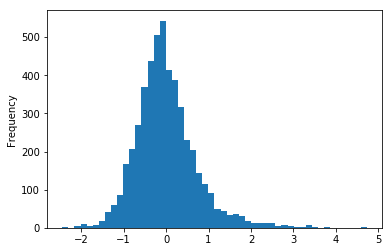

In [84]:
df['erro'].plot.hist(bins=50)

In [99]:
df['ratio'] = (df['budget']/1000000) / df['yhat']

In [120]:
list(df)

['color',
 'director_name',
 'num_critic_for_reviews',
 'duration',
 'director_facebook_likes',
 'actor_3_facebook_likes',
 'actor_2_name',
 'actor_1_facebook_likes',
 'genres',
 'actor_1_name',
 'num_voted_users',
 'cast_total_facebook_likes',
 'actor_3_name',
 'facenumber_in_poster',
 'movie_imdb_link',
 'num_user_for_reviews',
 'language',
 'country',
 'content_rating',
 'budget',
 'title_year',
 'actor_2_facebook_likes',
 'imdb_score',
 'aspect_ratio',
 'movie_facebook_likes',
 'yhat',
 'erro',
 'ratio']

In [ ]:
df['ye]

In [107]:
df[['yhat', 'imdb_score', 'erro', 'ratio', 'budget']].sort_values(by=['ratio']).head(10)

,yhat,imdb_score,erro,ratio,budget
4694,6.997978,7.2,-0.202022,0.000031,218.0
4936,6.635974,6.6,0.035974,0.000166,1100.0
4934,6.752799,6.3,0.452799,0.000207,1400.0
4930,6.658196,7.8,-1.141804,0.000488,3250.0
4920,6.571423,6.9,-0.328577,0.000685,4500.0
4927,7.323007,7.0,0.323007,0.000956,7000.0
4929,7.016109,6.9,0.116109,0.000998,7000.0
4928,6.561504,6.3,0.261504,0.001067,7000.0
4921,7.469673,7.5,-0.030327,0.001339,10000.0
4919,7.144639,6.1,1.044639,0.001400,10000.0


In [109]:
dados16 = pd.read_csv('imdb_test.zip')

In [122]:
'Action|Adventure|Thriller'.split('|')

['Action', 'Adventure', 'Thriller']

In [112]:
X = dados16[numericas].drop(['imdb_score'], axis=1)

In [113]:
dados16['imdb_score_predicted'] = model.predict(X)

In [116]:
dados16['ratio'] = (dados16['budget']/1000000) / dados16['imdb_score_predicted']

In [119]:
dados16.sort_values(by = ['ratio'])[['movie_title', 'budget']]

,movie_title,budget
101,Fight to the Finish,150000.0
104,The Little Ponderosa Zoo,500000.0
103,Rodeo Girl,500000.0
102,Alleluia! The Devil's Carnival,500000.0
98,The Dog Lover,2000000.0
93,Compadres,3000000.0
94,Antibirth,3500000.0
89,Airlift,4400000.0
92,The Masked Saint,3500000.0
90,The Veil,4000000.0


**4) Separar os dados em Treino e Teste** 

Esse ponto é crucial em machine learning e falaremos mais vezes sobre diferentes técnicas em "splitar" os dados.

**5) Treinar o Modelo para que o algoritmo descrubra os melhores betas (que produzem os menores erros)**

**6) Após treinar o modelo podemos analisar suas métricas e aqui é uma parte sensivel, vamos entender algumas métricas.**

Vamos entender primeiro as métricas e em seguida entender a diferença entre os números de treino e de teste.

**O que é o MSE e o MAE**
MSE: Erros médios quadraticos.
MAE: Erros médios absolutos.

Qual a diferença entre eles?

Pensemos no caso de um dataset com muitos outlinears, qual das duas métricas será mais prejudica (ou seja, qual métrica é mais sensivel a dados muito fora do padrão?). Nosso métrica ao quadrado é mais sensivel pois pegamos a diferença entre o valor predito e o realizado e elevamos ao quadrado tornando a diferença ainda maior. Já o MAE não é tão sensivel aos valores extremos pois consideramos apenas a distância absoluta que da o mesmo peso a distâncias grandes e pequenas.
Ex: Valor predito = 8, Valor Real = 5.
MAE= 8-5 = 3
MSE= (8-5)^2 = 9 -> Penaliza erros maiores.


Já o R2 é a mesma intepretação que demos em modelagem estatistica (% da variação de Y explicada por todas as variáveis explicativas X). Só que agora nosso objetivo é aumentar ao máximo nosso R2.



** Métricas de Treino e Métricas de Teste **

O grande objetivo de um modelo de aprendizado de maquina (ML) é termos um modelo que é preditivo para novos dados, ou seja, precisamos de um modelo que seja bastante genérico, que depois de treinado pode pegar dados que não estavam na amostra e consiga prever seu target com uma boa precisão.

Então ter boas métricas nos dados de treino não significam necessariamente que o modelo é um bom preditor. Para isso ele precisa ter boas métricas nos dados de teste! (aquela parte dos dados que separamos e não participaram do treino). Se nosso algoritmo é capaz de prever de maneira satisfatória nossos dados de teste (que são dados novos para ele já que não participaram do treino) esse é um bom modelo.

Quando as métricas dos dados de treino estão muito superiores aos dados de teste (como no nosso exemplo) significa que estamos fazendo um superajuste/sobreajuste ou como gostamos de chamar o modelo está com overfiting. Significa basicamente que nosso modelo se tornou especialista em prever nossos dados de treino mas não necessariamente é um bom modelo para prever dados fora do treinamento. Há muitas formas de contornar isso que veremos nas próximas aulas, mas a mais importante que faremos aqui é tentar equilibrar a complexidade do modelo, basicamente colocamos mais variáveis do que seria necessario.

É aqui que voltamos ao passo de escolher e tratar variaveis e rodamos tudo novamente.
Vamos fazer todos os processos na próxima linha e colocar um modelo um pouco mais simples:


<img src="img\overfit.png" style="height:250px">

In [28]:
# Vamos remover algumas colunas que podem estar causando um superajuste/overfiting no nosso modelo

Parece bem melhor agora, tanto o R2 aumentou como ficou mais parecido entre treino e teste sugerindo que não estou dando overfiting no modelo.

Podemos ainda criar modelos um pouco mais complexos inserindo formas quadraticas, cubicas, etc para tentar capturar algum efeito não linear nos dados.

Idealmente plotariamos as variáveis e escolheriamos as que fazem mais sentido colocar variaveis quadraticas, etc. Mas na prática rodamos um algoritmo para passar um polinomio em todas as nossas variáveis como no código abaixo:

Obs: Colocamos todos os passos da regressão em uma função para não termos que ficar repetindo mais códigos.

7) Após estarmos convictos que o modelo treinado tem uma boa relação entre o viés e variância (parametrizado pela complexidade do nosso modelo. Novamente, quanto mais complexo mais ele consegue capturar efeitos não previsto pelo modelo como comportamentos não lineares e interação das variáveis, mas tornando o modelo menos genérico, ou seja, diminuindo os scores dos dados de teste) vamos treinar o modelo final com os parâmetros que conseguiram os melhores resultados nos dados de teste.

# Passo 5 - Fazer Predições.

In [43]:
# Depois que temos o melhor modelo treinado vamos pegar os dados do mundo real e fazer previsão.

df2016_raw = pd.read_csv('../../99 Datasets/imdb_test.zip')
df2016 = df2016_raw.copy(deep=True)
df2016.head()

# nesse nosso caso, temos o target nos dados "reais", geralmente não o teriamos, 
# aqui poderemos saber a perfomance do nosso algoritmo

,Unnamed: 0,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,10,Color,Zack Snyder,673.0,183.0,0.0,2000.0,Lauren Cohan,15000.0,330249062.0,...,3018.0,English,USA,PG-13,250000000.0,2016.0,4000.0,6.9,2.35,197000.0
1,27,Color,Anthony Russo,516.0,147.0,94.0,11000.0,Scarlett Johansson,21000.0,407197282.0,...,1022.0,English,USA,PG-13,250000000.0,2016.0,19000.0,8.2,2.35,72000.0
2,57,Color,Justin Lin,322.0,122.0,681.0,105.0,Melissa Roxburgh,998.0,130468626.0,...,432.0,English,USA,PG-13,185000000.0,2016.0,119.0,7.5,2.35,30000.0
3,63,Color,David Yates,248.0,110.0,282.0,103.0,Alexander Skarsgård,11000.0,124051759.0,...,239.0,English,USA,PG-13,180000000.0,2016.0,10000.0,6.6,2.35,29000.0
4,65,Color,Bryan Singer,396.0,144.0,0.0,1000.0,Michael Fassbender,34000.0,154985087.0,...,622.0,English,USA,PG-13,178000000.0,2016.0,13000.0,7.3,2.35,54000.0


In [44]:
# Todos os tratamentos de dados que fizemos no dataset original precisamos refazer aqui:

df2016 = df2016.drop(columns_to_drop, axis=1)

df2016[list(df_numeric)] = df2016[list(df_numeric)].fillna(df2016.mean())

df2016 = df2016.fillna('na')

df2016 = pd.get_dummies(df2016)

Y2016 = df2016['imdb_score']

In [45]:
len(list(X))

1041

In [46]:
len(list(df2016))

587

In [47]:
for i, dummy in enumerate(list(X)):
    if dummy not in list(df2016):
        df2016[dummy] = 0

print(f'dummies adicionadas:{i}')

dummies adicionadas:1040


In [48]:
X2016 = df2016[list(X)]

In [49]:
yhat = final_model.predict(X2016)

In [50]:
# Perfeito! Temos um array com os valores previstos
yhat

array([ 6.64,  6.63,  5.98,  5.93,  6.1 ,  5.89,  5.71,  4.51,  5.02,
        5.86,  5.34,  5.93,  4.03,  6.47,  5.95,  5.69,  5.02,  5.81,
        5.74,  5.42,  5.55,  5.55,  6.08,  5.48,  5.82,  6.08,  6.31,
        5.74,  8.03,  5.68,  5.57,  6.39,  5.77,  6.61,  6.86,  5.86,
        6.48,  6.16,  5.85,  6.56,  4.15,  5.75,  5.58,  5.63,  4.34,
        5.71,  5.62,  6.74,  6.18,  6.74,  5.69,  6.13,  6.38,  5.91,
        6.72,  5.67,  6.33,  6.  ,  4.42,  5.73,  5.36,  6.66,  5.24,
        5.44,  6.12,  5.91,  5.67,  5.71,  6.56,  5.3 ,  5.89,  6.69,
        6.21,  6.8 ,  5.67,  5.27,  6.31,  5.41,  4.98,  5.94,  5.45,
        6.66,  4.95,  6.93,  5.22,  6.25,  5.38,  5.18,  5.29,  7.38,
        5.53,  5.67,  5.08,  5.01,  5.09,  6.9 ,  5.94,  6.11,  5.52,
        6.4 ,  6.4 ,  5.41,  5.17,  4.98,  6.33,  5.68])

In [51]:
# como podemos saber de qual filme se trata cada um dos score previstos?
# o algoritmo não diz qual é o nome do filme, mas a ordem em que passamos os dados se mantém ..
# então podemos adicionar uma coluna no nosso dataframe original com as predições!

df2016_raw['score_previsto'] = yhat
df2016_raw.head()

,Unnamed: 0,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,score_previsto
0,10,Color,Zack Snyder,673.0,183.0,0.0,2000.0,Lauren Cohan,15000.0,330249062.0,...,English,USA,PG-13,250000000.0,2016.0,4000.0,6.9,2.35,197000.0,6.64
1,27,Color,Anthony Russo,516.0,147.0,94.0,11000.0,Scarlett Johansson,21000.0,407197282.0,...,English,USA,PG-13,250000000.0,2016.0,19000.0,8.2,2.35,72000.0,6.63
2,57,Color,Justin Lin,322.0,122.0,681.0,105.0,Melissa Roxburgh,998.0,130468626.0,...,English,USA,PG-13,185000000.0,2016.0,119.0,7.5,2.35,30000.0,5.98
3,63,Color,David Yates,248.0,110.0,282.0,103.0,Alexander Skarsgård,11000.0,124051759.0,...,English,USA,PG-13,180000000.0,2016.0,10000.0,6.6,2.35,29000.0,5.93
4,65,Color,Bryan Singer,396.0,144.0,0.0,1000.0,Michael Fassbender,34000.0,154985087.0,...,English,USA,PG-13,178000000.0,2016.0,13000.0,7.3,2.35,54000.0,6.10


# Respondendo a pergunta do nosso Desafio:

In [52]:
result = df2016_raw[['movie_title','budget','score_previsto']]
result['ratio'] = (result['budget']/1000000)/(result['score_previsto'])

C:\Users\marce\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [53]:
# "piores" 10 filmes nas regras desse desafio, são os filmes que os scores custam mais caro.
result.sort_values(by=['ratio'], ascending=False).head(10)

,movie_title,budget,score_previsto,ratio
1,Captain America: Civil War,250000000.0,6.63,37.707391
0,Batman v Superman: Dawn of Justice,250000000.0,6.64,37.650602
7,Independence Day: Resurgence,165000000.0,4.51,36.585366
12,Ghostbusters,144000000.0,4.03,35.732010
40,Ghostbusters,144000000.0,4.15,34.698795
2,Star Trek Beyond,185000000.0,5.98,30.936455
6,The Jungle Book,175000000.0,5.71,30.647986
45,The Jungle Book,175000000.0,5.71,30.647986
11,The Legend of Tarzan,180000000.0,5.93,30.354132
3,The Legend of Tarzan,180000000.0,5.93,30.354132


In [54]:
# "melhores" 10 filmes nas regras desse desafio.
result.sort_values(by=['ratio'], ascending=True).head(10)

,movie_title,budget,score_previsto,ratio
101,Fight to the Finish,150000.0,5.41,0.027726
104,The Little Ponderosa Zoo,500000.0,6.33,0.078989
102,Alleluia! The Devil's Carnival,500000.0,5.17,0.096712
103,Rodeo Girl,500000.0,4.98,0.100402
98,The Dog Lover,2000000.0,5.52,0.362319
89,Airlift,4400000.0,7.38,0.596206
93,Compadres,3000000.0,5.01,0.598802
94,Antibirth,3500000.0,5.09,0.687623
92,The Masked Saint,3500000.0,5.08,0.688976
90,The Veil,4000000.0,5.53,0.723327


# Próximo passo, colocar o modelo em produção ...